# Quantifying the Invasiveness of _in silico_ Tumor Spheroids post-ICS Randomization

In [2]:
import numpy as np
import pandas as pd
import skimage as ski
import scipy as sp
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import cv2, pcdl, glob, os, time, math

In [3]:
# custom functions
import image_processing as ip
import invasiveness as iv
import pseudo_image_utils as piu
import utils

## Processing Hypothesis 1 Output with Permuted ICS

In [6]:
hypo1_simulation_results_df = pd.read_csv("../output/tables/hypothesis1_invasiveness_random_ics.csv")

In [8]:
hypo1_simulation_results_df.head()

,timepoint,sample_name,experimental_condition,n_invasive_projections,invasive_projection_heights,invasive_areas,spheroid_core_areas,invasive_area_ratios,hours
0,0h,sample_0,10_to_1,50.0,[272.90474529 272.24988522 279.83030572 269.77...,2773.098513,221007.901487,0.012548,0
1,24h,sample_0,10_to_1,113.0,[364.85750643 351.45981278 337.4803698 313.08...,22738.897965,257422.102035,0.088333,24
2,48h,sample_0,10_to_1,121.0,[359.06823864 341.52891532 349.12461958 342.46...,9009.615644,319719.884356,0.028180,48
3,72h,sample_0,10_to_1,204.0,[408.92542107 387.55257708 399.9324943 393.70...,15218.717257,369484.282743,0.041189,72
4,96h,sample_0,10_to_1,239.0,[442.18774293 429.86509512 419.00477324 403.71...,-2658.144251,489793.144251,-0.005427,96


In [9]:
## Plotting Utilities and Variables
def get_ratio_label(cat_str):
    if "only" in cat_str and "tumor" in cat_str:
        return f"1:0 Tumor:Fibroblast"
    elif "only" in cat_str and "fibroblast" in cat_str:
        return f"0:1 Tumor:Fibroblast"
    else:
        tumor = cat_str.split("_")[0]
        fibro = cat_str.split("_")[-1]
        return f"{tumor}:{fibro} Tumor:Fibroblast"

# Define jitter function to add random noise to the x-coordinates
def add_jitter(x, jitter_amount=0.1):
    return x + np.random.uniform(-jitter_amount, jitter_amount, size=len(x))

condition_markers = ['.', '^', '*', 'D', 's', 'x', 'v', '+', 'h', 'o', '>', '<']

# Use a color palette from Matplotlib's colormap (tab10 for 10 distinct colors)
cmap = plt.get_cmap('tab10', len(hypo1_simulation_results_df['experimental_condition'].unique()))
colors = {condition: cmap(i) for i, condition in enumerate(hypo1_simulation_results_df['experimental_condition'].unique())}
color_keys = list(colors.keys())

labels_raw = list(set(hypo1_simulation_results_df['experimental_condition']))
labels_proc = [get_ratio_label(l) for l in labels_raw]
output_labels_map = {k:p for k,p in zip(labels_raw, labels_proc)}

# setting x axis ticks and labels
xticks = list(np.unique(hypo1_simulation_results_df['hours'].values))
xlabels = sorted(list(np.unique(hypo1_simulation_results_df['timepoint'].values)), key=lambda x: int(''.join(filter(str.isdigit, str(x)))))

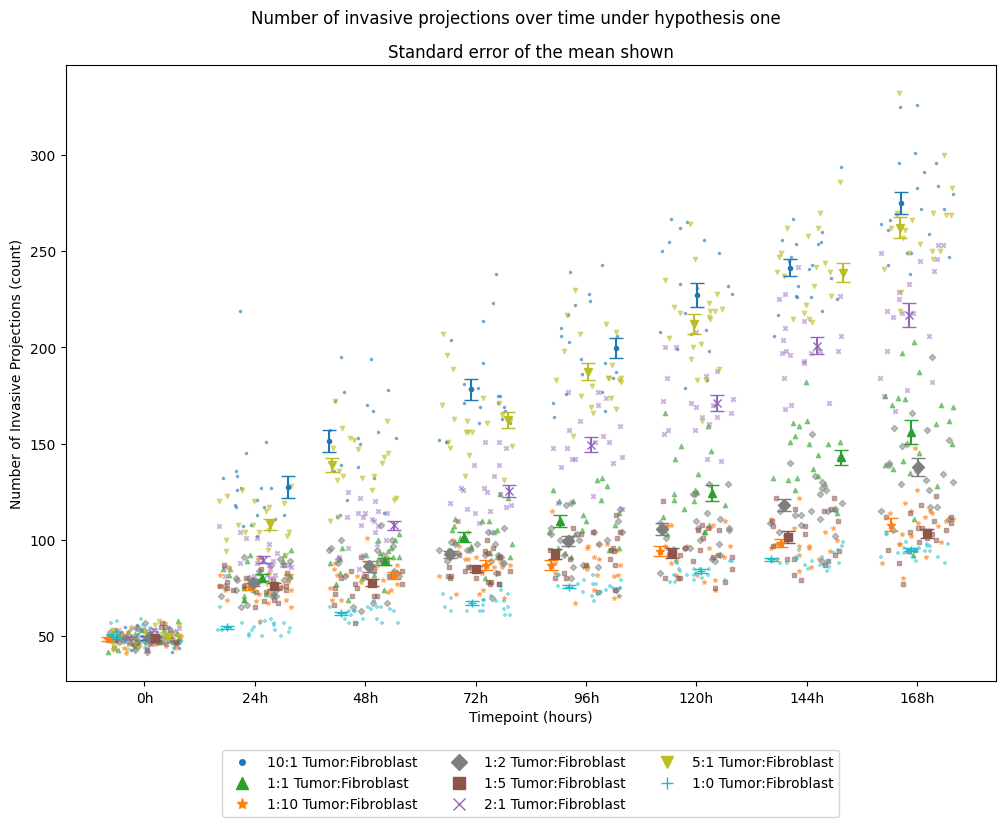

In [10]:
# Group by 'experimental_condition' and 'timepoint'
grouped = hypo1_simulation_results_df.groupby(['experimental_condition', 'hours'])

# Calculate mean and standard error for each group
mean_se_df = grouped['n_invasive_projections'].agg(['mean', 'sem']).reset_index()

# Ensure data is sorted by 'timepoint'
mean_se_df = mean_se_df.sort_values(by=['hours'])

fig, ax = plt.subplots(figsize=(12,8))

# plot the points with jitter
i=0
for key, grp in hypo1_simulation_results_df.groupby(['experimental_condition']):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    ax.scatter(
        list(jittered_timepoints), 
        grp['n_invasive_projections'], 
        marker=condition_markers[i], 
        alpha=0.5, 
        label=output_labels_map[key[0]], #grp['experimental_condition'].iloc[0],
        s = 10,
        color=colors[key[0]]
        )
    i += 1

# Plot the means with standard error bars
i=0
for key, grp in mean_se_df.groupby('experimental_condition'):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    # Add error bars for the mean with standard error
    ax.errorbar(
        list(jittered_timepoints), 
        grp['mean'], 
        yerr=grp['sem'], 
        fmt=condition_markers[i], 
        capsize=5, 
        alpha=1.0, 
        color=colors[key]
        )
    i+=1

# Custom legend with alpha=1
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for j, handle in enumerate(handles):
    label_color = handle.properties()['facecolor']
    #label_color[-1] = 1.0
    new_handle = plt.Line2D([], [], color=label_color, alpha=1.0, marker=condition_markers[j], linestyle='', markersize=8)
    new_handles.append(new_handle)

# Move the legend to below the x-axis
ax.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

# set the axis ticks and labels
ax.set_xticks(xticks)  # Set the ticks
ax.set_xticklabels(xlabels)  # Set the tick labels
ax.set_title("Standard error of the mean shown")
ax.set_xlabel("Timepoint (hours)")
ax.set_ylabel("Number of Invasive Projections (count)")
fig.suptitle("Number of invasive projections over time under hypothesis one", y=.95)
plt.show()

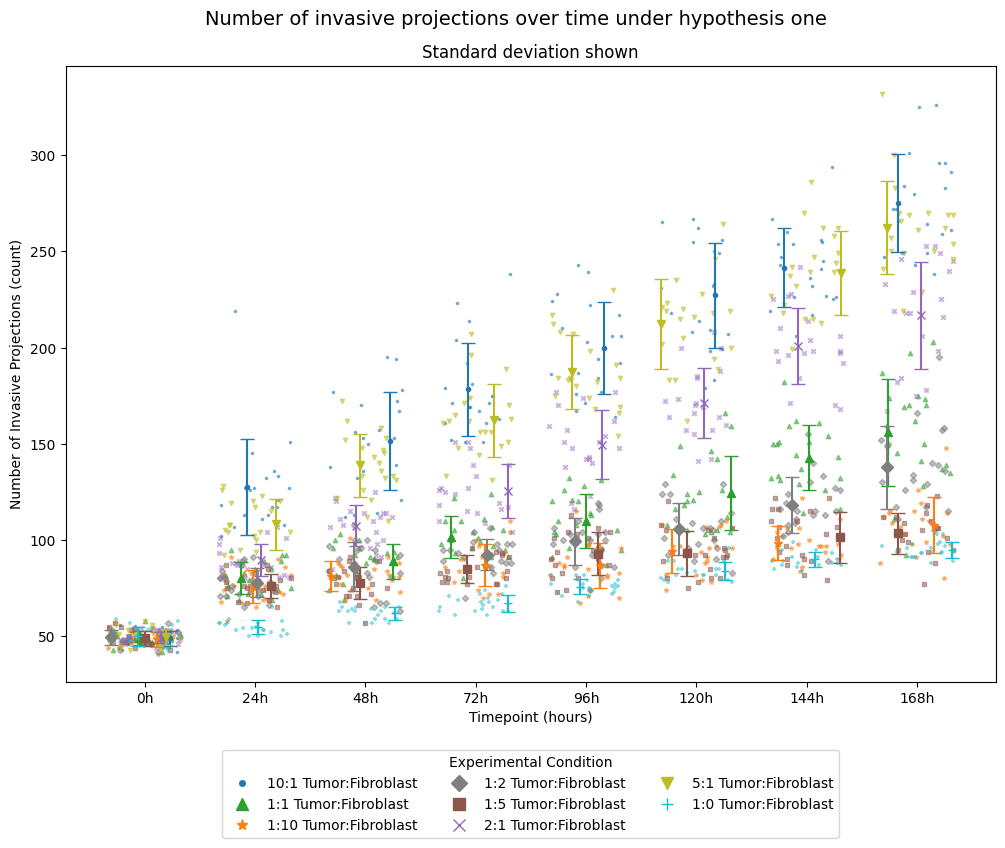

In [12]:
## Repeat of graph above, but using the standard deviation instead of the sem
# Group by 'experimental_condition' and 'timepoint'
grouped = hypo1_simulation_results_df.groupby(['experimental_condition', 'hours'])

# Calculate mean and standard error for each group
mean_se_df = grouped['n_invasive_projections'].agg(['mean', 'std']).reset_index()

# Ensure data is sorted by 'timepoint'
mean_se_df = mean_se_df.sort_values(by=['hours'])

fig, ax = plt.subplots(figsize=(12,8))

# plot the points with jitter
i=0
for key, grp in hypo1_simulation_results_df.groupby(['experimental_condition']):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    ax.scatter(
        list(jittered_timepoints), 
        grp['n_invasive_projections'], 
        marker=condition_markers[i], 
        alpha=0.5, 
        label=output_labels_map[key[0]], #grp['experimental_condition'].iloc[0],
        s = 10,
        color=colors[key[0]]
        )
    i += 1

# Plot the means with standard error bars
i=0
for key, grp in mean_se_df.groupby('experimental_condition'):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    # Add error bars for the mean with standard error
    ax.errorbar(
        list(jittered_timepoints), 
        grp['mean'], 
        yerr=grp['std'], 
        fmt=condition_markers[i], 
        capsize=5, 
        alpha=1.0, 
        color=colors[key]
        )
    i+=1

# Custom legend with alpha=1
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for j, handle in enumerate(handles):
    label_color = handle.properties()['facecolor']
    new_handle = plt.Line2D([], [], color=label_color, alpha=1.0, marker=condition_markers[j], linestyle='', markersize=8)
    new_handles.append(new_handle)

# Move the legend to below the x-axis
ax.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, title="Experimental Condition")

# set the axis ticks and labels
ax.set_xticks(xticks)  # Set the ticks
ax.set_xticklabels(xlabels)  # Set the tick labels
ax.set_title("Standard deviation shown")
ax.set_xlabel("Timepoint (hours)")
ax.set_ylabel("Number of Invasive Projections (count)")
fig.suptitle("Number of invasive projections over time under hypothesis one", fontsize=14, y=0.95)
plt.show()

## Processing Hypothesis 2 Output with Permuted ICS

In [78]:
hypo2_simulation_results_df = pd.read_csv("../output/tables/hypothesis2_invasiveness_random_ics.csv")

In [82]:
# swap the 2:1 and 1:2 ratios to account for mistake in naming
one_to_two = hypo2_simulation_results_df.index[hypo2_simulation_results_df['experimental_condition'] == "1_to_2"]
two_to_one = hypo2_simulation_results_df.index[hypo2_simulation_results_df['experimental_condition'] == "2_to_1"]
hypo2_simulation_results_df.loc[one_to_two, 'experimental_condition'] = "2_to_1"
hypo2_simulation_results_df.loc[two_to_one, 'experimental_condition'] = "1_to_2"

In [9]:
hypo2_simulation_results_df.head()

,sample_name,experimental_condition,n_invasive_projections,invasive_projection_heights,invasive_areas,spheroid_core_areas,invasive_area_ratios,hours
timepoint,,,,,,,,
0h,sample_0,10_to_1,48.0,"[265.228203628498, 272.90474528670256, 272.249...",2802.974533,220877.525467,0.012690,0
24h,sample_0,10_to_1,115.0,"[340.0132350365203, 338.42724476613876, 326.61...",1638.634582,280547.365418,0.005841,24
48h,sample_0,10_to_1,138.0,"[371.0862433451286, 368.84820726146955, 359.70...",4877.316560,339562.183440,0.014364,48
72h,sample_0,10_to_1,185.0,"[423.265873890159, 408.2560471076944, 399.0100...",-14306.512525,425701.512525,-0.033607,72
96h,sample_0,10_to_1,247.0,"[444.01801765243715, 437.0286031829038, 439.13...",-10355.245988,542069.245988,-0.019103,96


In [83]:
## Plotting Utilities and Variables
def get_ratio_label(cat_str):
    if "only" in cat_str and "tumor" in cat_str:
        return f"1:0 Tumor:Fibroblast"
    elif "only" in cat_str and "fibroblast" in cat_str:
        return f"0:1 Tumor:Fibroblast"
    else:
        tumor = cat_str.split("_")[0]
        fibro = cat_str.split("_")[-1]
        return f"{tumor}:{fibro} Tumor:Fibroblast"

# Define jitter function to add random noise to the x-coordinates
def add_jitter(x, jitter_amount=0.1):
    return x + np.random.uniform(-jitter_amount, jitter_amount, size=len(x))

condition_markers = ['.', '^', '*', 'D', 's', 'x', 'v', '+', 'h', 'o', '>', '<']

# Use a color palette from Matplotlib's colormap (tab10 for 10 distinct colors)
cmap = plt.get_cmap('tab10', len(hypo2_simulation_results_df['experimental_condition'].unique()))
colors = {condition: cmap(i) for i, condition in enumerate(hypo2_simulation_results_df['experimental_condition'].unique())}
color_keys = list(colors.keys())

labels_raw = list(set(hypo2_simulation_results_df['experimental_condition']))
labels_proc = [get_ratio_label(l) for l in labels_raw]
output_labels_map = {k:p for k,p in zip(labels_raw, labels_proc)}

# setting x axis ticks and labels
xticks = list(np.unique(hypo2_simulation_results_df['hours'].values))
xlabels = sorted(list(np.unique(hypo2_simulation_results_df['timepoint'].values)), key=lambda x: int(''.join(filter(str.isdigit, str(x)))))

### Number of Invasive Projections

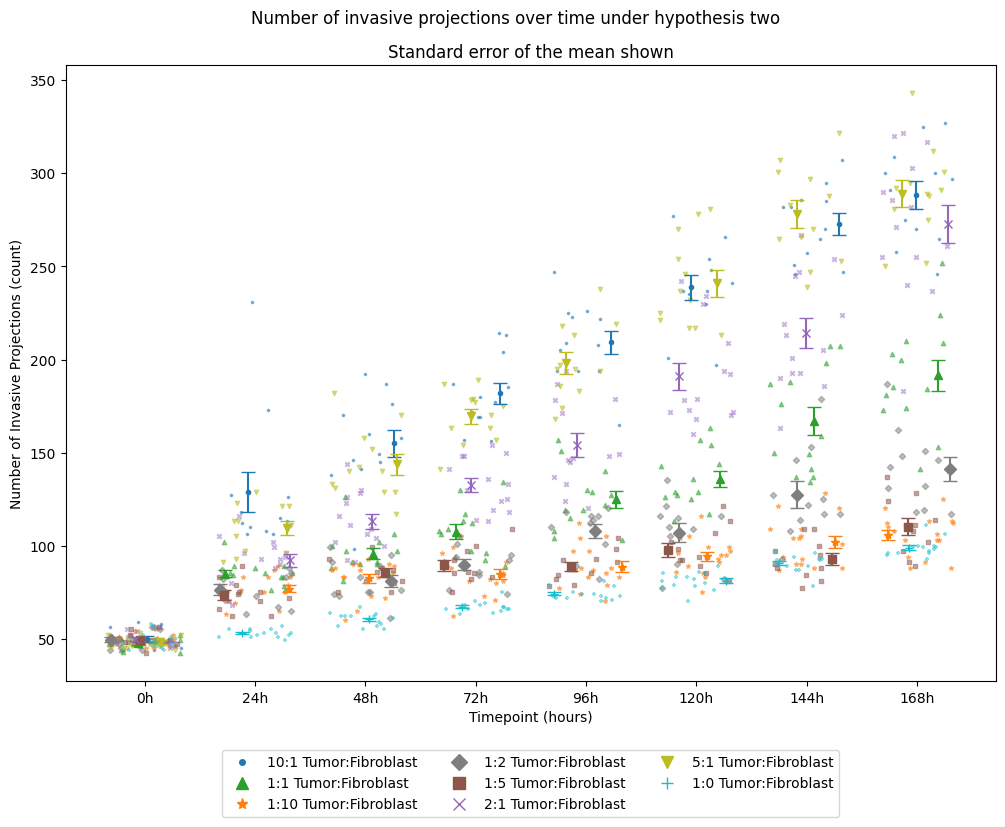

In [84]:
# Group by 'experimental_condition' and 'timepoint'
grouped = hypo2_simulation_results_df.groupby(['experimental_condition', 'hours'])

# Calculate mean and standard error for each group
mean_se_df = grouped['n_invasive_projections'].agg(['mean', 'sem']).reset_index()

# Ensure data is sorted by 'timepoint'
mean_se_df = mean_se_df.sort_values(by=['hours'])

fig, ax = plt.subplots(figsize=(12,8))

# plot the points with jitter
i=0
for key, grp in hypo2_simulation_results_df.groupby(['experimental_condition']):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    ax.scatter(
        list(jittered_timepoints), 
        grp['n_invasive_projections'], 
        marker=condition_markers[i], 
        alpha=0.5, 
        label=output_labels_map[key[0]], #grp['experimental_condition'].iloc[0],
        s = 10,
        color=colors[key[0]]
        )
    i += 1

# Plot the means with standard error bars
i=0
for key, grp in mean_se_df.groupby('experimental_condition'):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    # Add error bars for the mean with standard error
    ax.errorbar(
        list(jittered_timepoints), 
        grp['mean'], 
        yerr=grp['sem'], 
        fmt=condition_markers[i], 
        capsize=5, 
        alpha=1.0, 
        color=colors[key]
        )
    i+=1

# Custom legend with alpha=1
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for j, handle in enumerate(handles):
    label_color = handle.properties()['facecolor']
    new_handle = plt.Line2D([], [], color=label_color, alpha=1.0, marker=condition_markers[j], linestyle='', markersize=8)
    new_handles.append(new_handle)

# Move the legend to below the x-axis
ax.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

# set the axis ticks and labels
ax.set_xticks(xticks)  # Set the ticks
ax.set_xticklabels(xlabels)  # Set the tick labels
ax.set_title("Standard error of the mean shown")
ax.set_xlabel("Timepoint (hours)")
ax.set_ylabel("Number of Invasive Projections (count)")
fig.suptitle("Number of invasive projections over time under hypothesis two", y=.95)
plt.show()

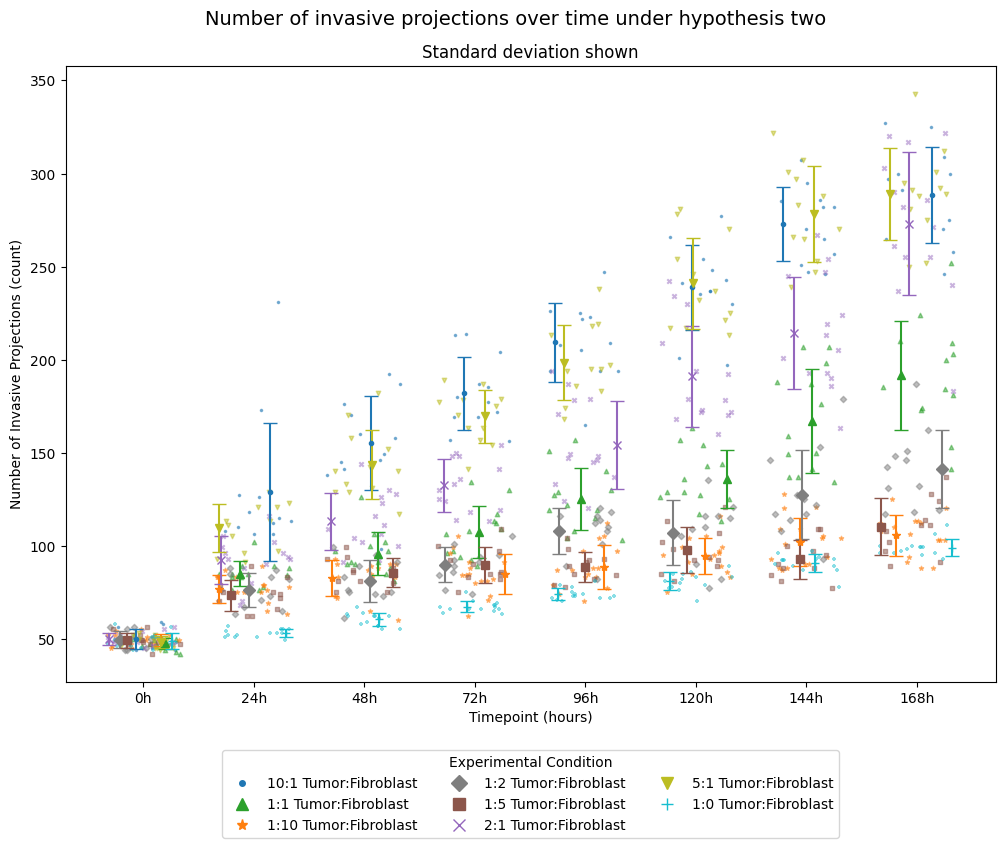

In [85]:
## Repeat of graph above, but using the standard deviation instead of the sem
# Group by 'experimental_condition' and 'timepoint'
grouped = hypo2_simulation_results_df.groupby(['experimental_condition', 'hours'])

# Calculate mean and standard error for each group
mean_se_df = grouped['n_invasive_projections'].agg(['mean', 'std']).reset_index()

# Ensure data is sorted by 'timepoint'
mean_se_df = mean_se_df.sort_values(by=['hours'])

fig, ax = plt.subplots(figsize=(12,8))

# plot the points with jitter
i=0
for key, grp in hypo2_simulation_results_df.groupby(['experimental_condition']):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    ax.scatter(
        list(jittered_timepoints), 
        grp['n_invasive_projections'], 
        marker=condition_markers[i], 
        alpha=0.5, 
        label=output_labels_map[key[0]], #grp['experimental_condition'].iloc[0],
        s = 10,
        color=colors[key[0]]
        )
    i += 1

# Plot the means with standard error bars
i=0
for key, grp in mean_se_df.groupby('experimental_condition'):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    # Add error bars for the mean with standard error
    ax.errorbar(
        list(jittered_timepoints), 
        grp['mean'], 
        yerr=grp['std'], 
        fmt=condition_markers[i], 
        capsize=5, 
        alpha=1.0, 
        color=colors[key]
        )
    i+=1

# Custom legend with alpha=1
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for j, handle in enumerate(handles):
    label_color = handle.properties()['facecolor']
    new_handle = plt.Line2D([], [], color=label_color, alpha=1.0, marker=condition_markers[j], linestyle='', markersize=8)
    new_handles.append(new_handle)

# Move the legend to below the x-axis
ax.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, title="Experimental Condition")

# set the axis ticks and labels
ax.set_xticks(xticks)  # Set the ticks
ax.set_xticklabels(xlabels)  # Set the tick labels
ax.set_title("Standard deviation shown")
ax.set_xlabel("Timepoint (hours)")
ax.set_ylabel("Number of Invasive Projections (count)")
fig.suptitle("Number of invasive projections over time under hypothesis two", fontsize=14, y=0.95)
plt.show()

## Figure Generation
### Plotting Utility Function

In [72]:
## Plotting Utilities and Variables
def get_ratio_label(cat_str):
    if "only" in cat_str and "tumor" in cat_str:
        return f"1:0 Tumor:Fibroblast"
    elif "only" in cat_str and "fibroblast" in cat_str:
        return f"0:1 Tumor:Fibroblast"
    else:
        tumor = cat_str.split("_")[0]
        fibro = cat_str.split("_")[-1]
        return f"{tumor}:{fibro} Tumor:Fibroblast"

# Define jitter function to add random noise to the x-coordinates
def add_jitter(x, jitter_amount=0.1):
    return x + np.random.uniform(-jitter_amount, jitter_amount, size=len(x))

def plot_jitter_errbars(
    df,
    group_var,
    x_tick_var,
    x_label_var,
    y_var,
    ax=None,
    err_type='sem',
    condition_markers = ['.', '^', '*', 'D', 's', 'x', 'v', '+', 'h', 'o', '>', '<']
):

    # Use a color palette from Matplotlib's colormap (tab10 for 10 distinct colors)
    cmap = plt.get_cmap('tab10', len(df[group_var].unique()))
    colors = {condition: cmap(i) for i, condition in enumerate(df[group_var].unique())}
    color_keys = list(colors.keys())

    labels_raw = list(set(df[group_var]))
    labels_proc = [get_ratio_label(l) for l in labels_raw]
    output_labels_map = {k:p for k,p in zip(labels_raw, labels_proc)}

    # setting x axis ticks and labels
    xticks = list(np.unique(df[x_tick_var].values))
    xlabels = sorted(list(np.unique(df[x_label_var].values)), key=lambda x: int(''.join(filter(str.isdigit, str(x)))))

    # Group by 'experimental_condition' and 'timepoint'
    grouped = df.groupby([group_var, x_tick_var])

    # Calculate mean and standard error for each group
    mean_se_df = grouped[y_var].agg(['mean', err_type]).reset_index()

    # Ensure data is sorted by 'timepoint'
    mean_se_df = mean_se_df.sort_values(by=[x_tick_var])

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    

    # plot the points with jitter
    i=0
    for key, grp in df.groupby([group_var]):
        jittered_timepoints = add_jitter(grp[x_tick_var].values, jitter_amount=8)  # Add jitter to timepoints
        ax.scatter(
            list(jittered_timepoints), 
            grp[y_var], 
            marker=condition_markers[i], 
            alpha=0.5, 
            label=output_labels_map[key[0]], 
            s = 10,
            color=colors[key[0]]
            )
        i += 1

    # Plot the means with standard error bars
    i=0
    for key, grp in mean_se_df.groupby(group_var):
        jittered_timepoints = add_jitter(grp[x_tick_var].values, jitter_amount=8)  # Add jitter to timepoints
        # Add error bars for the mean with standard error
        ax.errorbar(
            list(jittered_timepoints), 
            grp['mean'], 
            yerr=grp[err_type], 
            fmt=condition_markers[i], 
            capsize=5, 
            alpha=1.0, 
            color=colors[key]
            )
        i+=1

    # Custom legend with alpha=1
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    for j, handle in enumerate(handles):
        label_color = handle.properties()['facecolor']
        new_handle = plt.Line2D([], [], color=label_color, alpha=1.0, marker=condition_markers[j], linestyle='', markersize=8)
        new_handles.append(new_handle)

    # Move the legend to below the x-axis
    ax.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    # set the axis ticks and labels
    ax.set_xticks(xticks)  # Set the ticks
    ax.set_xticklabels(xlabels)  # Set the tick labels
    #ax.set_title("Standard error of the mean shown")
    #ax.set_xlabel("Timepoint (hours)")
    #ax.set_ylabel("Number of Invasive Projections (count)")

#fig.suptitle("Number of invasive projections over time under hypothesis two", y=.95)
#plt.show()

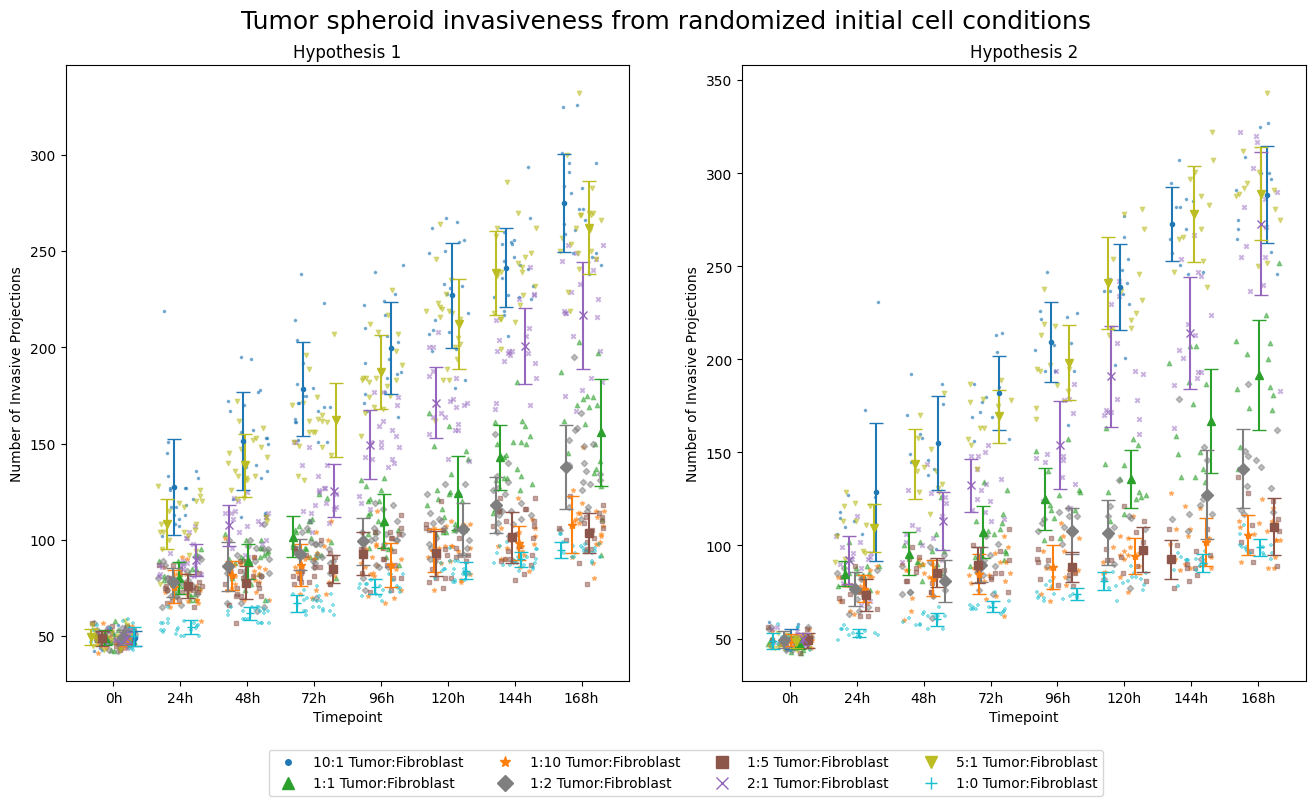

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax = ax.ravel()
plot_jitter_errbars(
    hypo1_simulation_results_df, 
    group_var = 'experimental_condition', 
    x_tick_var = 'hours', 
    x_label_var = 'timepoint', 
    y_var = 'n_invasive_projections',
    ax = ax[0],
    err_type='std'
)
ax[0].set_title('Hypothesis 1')
ax[0].set_ylabel('Number of Invasive Projections')
ax[0].set_xlabel('Timepoint')
ax[0].get_legend().remove()

plot_jitter_errbars(
    hypo2_simulation_results_df, 
    group_var = 'experimental_condition', 
    x_tick_var = 'hours', 
    x_label_var = 'timepoint', 
    y_var = 'n_invasive_projections',
    ax = ax[1],
    err_type='std'
)
ax[1].set_title('Hypothesis 2')
ax[1].set_ylabel('Number of Invasive Projections')
ax[1].set_xlabel('Timepoint')

# add and enhance legend
handles, labels = ax[1].get_legend_handles_labels()
new_handles = []
for j, handle in enumerate(handles):
    label_color = handle.properties()['facecolor']
    new_handle = plt.Line2D([], [], color=label_color, alpha=1.0, marker=condition_markers[j], linestyle='', markersize=8)
    new_handles.append(new_handle)
ax[1].legend(new_handles, labels, bbox_to_anchor=[-0.1, -0.1], ncol=4, loc='upper center')

fig.suptitle('Tumor spheroid invasiveness from randomized initial cell conditions', y=0.95, fontsize=18)
plt.savefig("../output/figures/randomized_ics.pdf", dpi=300, bbox_inches='tight')
plt.show()